In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', palette='deep')

In [174]:
df = pd.read_csv('cleaned_dataset.csv')
df = df.drop(labels = ["Id"],axis = 1)
df = df.drop(labels = ["ActivityDate"],axis = 1)

In [175]:
train, test = train_test_split(df, test_size=0.2)
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Transformation

In [176]:
for feature in dataset.columns:
    dataset[feature] = np.log1p(dataset[feature])

In [177]:
Y = dataset["Calories"]
dataset = dataset.drop(labels="Calories",axis = 1)

## Normalization

In [178]:
N = RobustScaler()

N.fit(dataset)

dataset = N.transform(dataset)

In [179]:
X_train = dataset[:train_len]
test = dataset[train_len:]
Y_train = Y[:train_len]

## Modelling

In [180]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)

In [181]:
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [182]:
lasso_rmse = RMSE(lassocv, X_train, Y_train)
RMSE(lassocv, X_train, Y_train)

0.33688868940342087

In [183]:
ridge_rmse = RMSE(ridge, X_train, Y_train)
RMSE(ridge, X_train, Y_train)

0.3371979924086886

In [184]:
lassolars_rmse = RMSE(lassolarscv, X_train, Y_train)
RMSE(lassolarscv, X_train, Y_train)

0.3383885249278469

In [185]:
elasticnet_rmse = RMSE(elasticnetcv, X_train, Y_train)
RMSE(elasticnetcv, X_train, Y_train)

0.3369948798744238

In [186]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)

ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=1e-15, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [187]:
Y_pred_lassocv = (lassocv.predict(test))
Y_pred_lassolarscv = (lassolarscv.predict(test))
Y_pred_elasticnetcv = (elasticnetcv.predict(test))
Y_pred_ridge = (ridge.predict(test))

In [188]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)
xgb_rmse = RMSE(model_xgb,X_train,Y_train)
RMSE(model_xgb,X_train,Y_train)

0.32423229787452523

In [189]:
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = (model_xgb.predict(test))

[04:39:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [190]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
gboost_rmse = RMSE(GBoost,X_train,Y_train)
RMSE(GBoost,X_train,Y_train)

0.3047652671447105

In [191]:
GBoost.fit(X_train,Y_train)
Y_pred_GBoost = (GBoost.predict(test))

<Figure size 432x288 with 0 Axes>

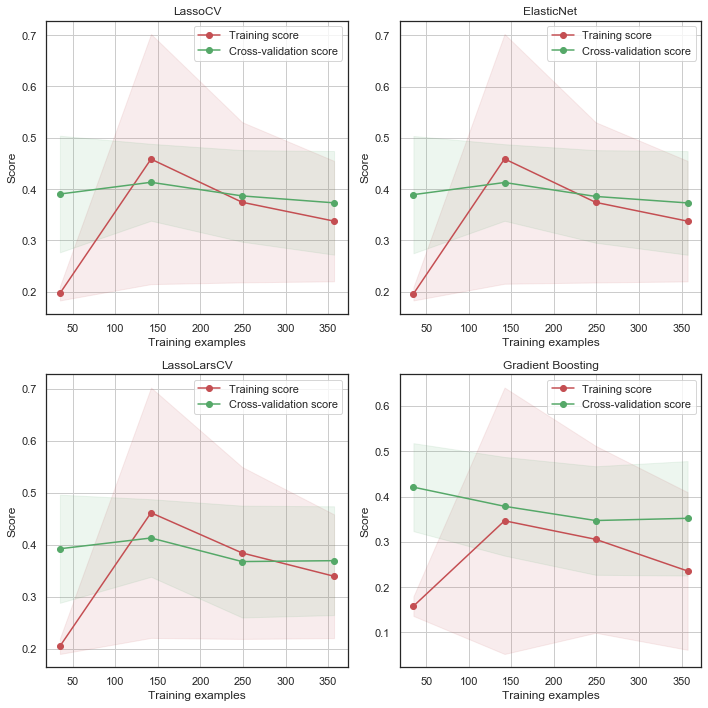

<Figure size 432x288 with 0 Axes>

In [192]:
def plot_learning_curves(estimators, titles, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 4)):
    """Generate a simple plot of the test and training learning curve"""
    nrows = len(estimators)//2
    ncols = (len(estimators)//nrows)+ (0 if len(estimators) % nrows == 0 else 1)
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    
    n = 0
    for col in range(ncols):
        for row in range(nrows):
            estimator = estimators[n]
            title = titles[n]
            axes[row,col].set_title(title)
            
            if ylim is not None:
                axes[row,col].set_ylim(*ylim)
            
            axes[row,col].set_xlabel("Training examples")
            axes[row,col].set_ylabel("Score")
            
            train_sizes, train_scores, test_scores = learning_curve(estimator,
                    X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
                    scoring="neg_mean_squared_error")
    
            train_scores = np.sqrt(-train_scores)
            test_scores = np.sqrt(-test_scores)
    
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            axes[row,col].grid()
        
            axes[row,col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
            axes[row,col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
            axes[row,col].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            axes[row,col].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
            axes[row,col].legend(loc="best")
            
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

    

estimators = [lassocv,lassolarscv,elasticnetcv,GBoost]
titles = ["LassoCV","LassoLarsCV","ElasticNet","Gradient Boosting",]

plot_learning_curves(estimators, titles, X_train, Y_train, cv=2 ,n_jobs=4)

In [193]:
lasso = lasso_rmse/(lasso_rmse+lassolars_rmse+ridge_rmse+ elasticnet_rmse)
lasslards = lassolars_rmse/(lasso_rmse+lassolars_rmse+ridge_rmse+ elasticnet_rmse)
ridge = ridge_rmse/(lasso_rmse+lassolars_rmse+ridge_rmse+ elasticnet_rmse)
elasticnet = elasticnet_rmse/(lasso_rmse+lassolars_rmse+ridge_rmse+ elasticnet_rmse)

In [194]:
lin = (lasso_rmse+lassolars_rmse+ridge_rmse+ elasticnet_rmse)/(lasso_rmse+lassolars_rmse+ridge_rmse+elasticnet_rmse+xgb_rmse+gboost_rmse)
xgb = xgb_rmse/(lasso_rmse+lassolars_rmse+ridge_rmse+elasticnet_rmse+xgb_rmse+gboost_rmse)
gboost = gboost_rmse/(lasso_rmse+lassolars_rmse+ridge_rmse+elasticnet_rmse+xgb_rmse+gboost_rmse)


In [195]:
predicted_Y = ((Y_pred_lassocv*lasso + Y_pred_elasticnetcv*elasticnet + Y_pred_ridge*ridge
                         + Y_pred_lassolarscv*lasslards))*lin + Y_pred_xgb*xgb + Y_pred_GBoost*gboost

## Root Mean Squared Error

In [196]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(np.array(Y_test), predicted_Y)
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.4353937991308361


Sources: https://www.kaggle.com/yassineghouzam/eda-introduction-to-ensemble-regression